In [276]:
# Import the libraries

import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt 
%matplotlib inline

import re

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.corpus import wordnet

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from pprint import pprint

import spacy
from spacy_langdetect import LanguageDetector


Code references: 

https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664

https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

## Data Exploration

In [277]:
df = pd.read_excel('programming_for_everybody.xlsx')

In [278]:
df

,date,review,rating,status
0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer
1,2021-03-11,Super easy and totally for the beginners like ...,5,completer
2,2021-03-11,Very interactive and a nice course to start pr...,5,completer
3,2021-03-11,Awesome course! Definitely a very nice introdu...,5,completer
4,2021-03-11,Perfect for new learners,5,completer
...,...,...,...,...
10116,2020-07-21,excellent explanation starting with how comput...,5,dropout
10117,2020-07-21,My friend recommanded the lecture. It really d...,5,dropout
10118,2020-07-21,Highly recommend this sets a good foundation ...,5,dropout
10119,2020-07-21,best python programming course for absolute be...,5,dropout


In [279]:
df.shape

(10121, 4)

In [280]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10121 entries, 0 to 10120
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    10121 non-null  object
 1   review  10119 non-null  object
 2   rating  10121 non-null  int64 
 3   status  10121 non-null  object
dtypes: int64(1), object(3)
memory usage: 316.4+ KB


In [281]:
df.nunique()

date       234
review    8599
rating       5
status       2
dtype: int64

In [282]:
# Top 10 most common reviews

df['review'].value_counts().head(10)  

good           182
nice           152
Good            57
very good       45
excellent       41
Excellent       39
Nice            33
nice course     32
great           30
good course     27
Name: review, dtype: int64

In [283]:
# duplicates seem to be from different learners

df[(df.review == 'good')]

,date,review,rating,status
116,2021-03-06,good,5,completer
117,2021-03-06,good,5,completer
123,2021-03-06,good,4,completer
131,2021-03-06,good,5,completer
213,2021-03-01,good,5,completer
...,...,...,...,...
10052,2020-07-21,good,3,completer
10060,2020-07-21,good,5,completer
10061,2020-07-21,good,5,completer
10065,2020-07-21,good,5,completer


In [284]:
# Most reviews have a good rating - the dataset is not balanced, there should be more positive than negative reviews

df['rating'].value_counts()

5    8925
4    1033
3      99
1      37
2      27
Name: rating, dtype: int64

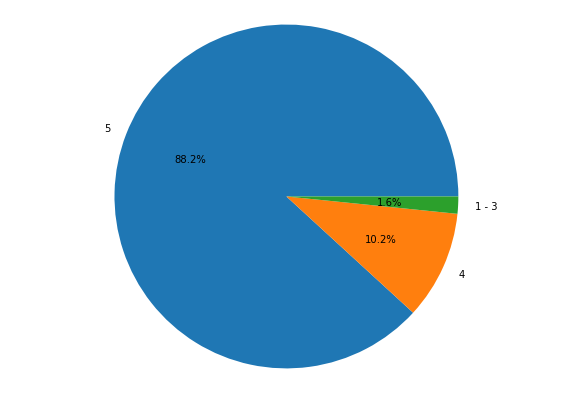

In [285]:
# Most people have given a rating of 5

plt.figure(figsize =(10, 7)) 
plt.pie([8925, 1033, 163], labels = ['5', '4', '1 - 3'], autopct='%1.1f%%');
plt.axis('equal')
plt.show()

In [286]:
# Check null values

df.isnull().sum() * 100 / df.shape[0]  

date      0.000000
review    0.019761
rating    0.000000
status    0.000000
dtype: float64

In [287]:
# Count null values in 'review'

len(df[df['review'].isna()==True])


2

In [288]:
# Drop null values

df.dropna(inplace = True)


In [289]:
# Count null values in 'review'

len(df[df['review'].isna()==True])


0

In [290]:
df.shape

(10119, 4)

In [291]:
# Create column 'length'

df['length'] = df['review'].astype(str).apply(len)
df.head()

,date,review,rating,status,length
0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,135
1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,163
2,2021-03-11,Very interactive and a nice course to start pr...,5,completer,67
3,2021-03-11,Awesome course! Definitely a very nice introdu...,5,completer,166
4,2021-03-11,Perfect for new learners,5,completer,24


In [292]:
# The average length of a review is 77 words - reviews are in general short

df['length'].describe()

count    10119.000000
mean        77.132424
std         99.033848
min          1.000000
25%         18.000000
50%         45.000000
75%         98.000000
max       1902.000000
Name: length, dtype: float64

In [293]:
# The longest reviews have a rating of 1-2. Shortest reviews have a rating of 3. 

px.box(df, x = "rating", y = "length")

In [294]:
# Remove reviews with less than three charaters

df_1 = df[df['length'] > 2]

In [295]:
df_1.length.describe()

count    10039.000000
mean        77.736528
std         99.195266
min          3.000000
25%         19.000000
50%         45.000000
75%         98.000000
max       1902.000000
Name: length, dtype: float64

In [296]:
df_1.shape

(10039, 5)

In [297]:
# Reset the index

df_1 = df_1.reset_index(drop = True)

In [298]:
df_1

,date,review,rating,status,length
0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,135
1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,163
2,2021-03-11,Very interactive and a nice course to start pr...,5,completer,67
3,2021-03-11,Awesome course! Definitely a very nice introdu...,5,completer,166
4,2021-03-11,Perfect for new learners,5,completer,24
...,...,...,...,...,...
10034,2020-07-21,excellent explanation starting with how comput...,5,dropout,129
10035,2020-07-21,My friend recommanded the lecture. It really d...,5,dropout,69
10036,2020-07-21,Highly recommend this sets a good foundation ...,5,dropout,56
10037,2020-07-21,best python programming course for absolute be...,5,dropout,53


In [299]:
# Label reviews as positive, negative and neutral depending on their rating

label = []

for row in df_1['rating']:
    if row == 1 or row == 2:
        label.append('neg')
    elif row == 3:
        label.append('neu')
    else:
        label.append('pos')

In [300]:
df_1['label'] = label

In [301]:
df_1.head()

,date,review,rating,status,length,label
0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,135,pos
1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,163,pos
2,2021-03-11,Very interactive and a nice course to start pr...,5,completer,67,pos
3,2021-03-11,Awesome course! Definitely a very nice introdu...,5,completer,166,pos
4,2021-03-11,Perfect for new learners,5,completer,24,pos


In [302]:
df_1['label'].value_counts()

pos    9881
neu      97
neg      61
Name: label, dtype: int64

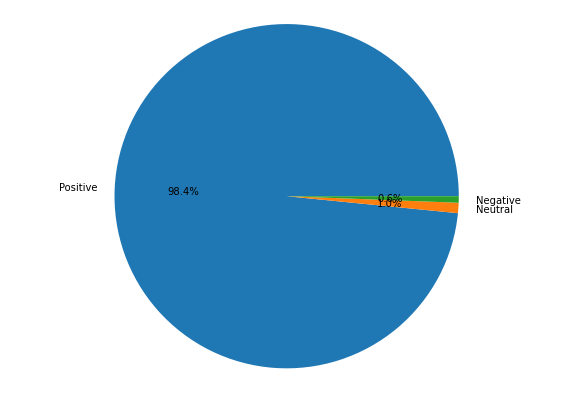

In [303]:
# 98 % of the reviews are positive according to the rating

plt.figure(figsize =(10, 7)) 
plt.pie([9881, 97, 61], labels = ['Positive', 'Neutral', 'Negative'], autopct='%1.1f%%');
plt.axis('equal')
plt.show()

In [304]:
# Define language detector using spacy

nlp = spacy.load('en_core_web_sm')
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)

In [305]:
# Detect language of reviews

language = []

for row in df_1['review']:
    doc = nlp(row)
    language.append(doc._.language)


In [306]:
df_1['language_score'] = language

In [307]:
df_1.language_score

0        {'language': 'en', 'score': 0.9999959963304478}
1         {'language': 'en', 'score': 0.999997173879746}
2        {'language': 'en', 'score': 0.9999975268736858}
3        {'language': 'en', 'score': 0.9999976641700863}
4        {'language': 'en', 'score': 0.9999971220715409}
                              ...                       
10034    {'language': 'en', 'score': 0.9999959212377021}
10035     {'language': 'en', 'score': 0.999997698016753}
10036    {'language': 'en', 'score': 0.9999971066672834}
10037    {'language': 'en', 'score': 0.9999948707398018}
10038    {'language': 'nl', 'score': 0.9999947640673078}
Name: language_score, Length: 10039, dtype: object

In [308]:
df_1['language']  = df_1['language_score'].apply(lambda score_dict: score_dict['language'])


In [309]:
df_1['language'].value_counts()

en         7927
so          317
es          290
fr          267
af          211
pl          183
ro          183
ca          166
no          113
de           68
pt           44
it           31
sw           31
cy           30
tl           23
nl           19
vi           18
sl           18
da           17
id           15
cs           15
hr           10
fi            9
UNKNOWN       8
sq            6
hu            6
et            4
sk            4
tr            3
sv            2
lt            1
Name: language, dtype: int64

In [310]:
# We only want to keep reviews in English
# After checking the language classifications we decide to remove reviews classified as 
# Spanish, Partugese, Hungarian, Slovakian, Lithuanian and UNKNOWN

df_1[df_1['language'] == 'uk']

,date,review,rating,status,length,label,language_score,language


In [311]:
exclude = ['es','pt', 'hu', 'sk', 'lt', 'UNKNOWN']

In [312]:
df_en = df_1[~df_1['language'].isin(exclude)]


In [313]:
df_en

,date,review,rating,status,length,label,language_score,language
0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,135,pos,"{'language': 'en', 'score': 0.9999959963304478}",en
1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,163,pos,"{'language': 'en', 'score': 0.999997173879746}",en
2,2021-03-11,Very interactive and a nice course to start pr...,5,completer,67,pos,"{'language': 'en', 'score': 0.9999975268736858}",en
3,2021-03-11,Awesome course! Definitely a very nice introdu...,5,completer,166,pos,"{'language': 'en', 'score': 0.9999976641700863}",en
4,2021-03-11,Perfect for new learners,5,completer,24,pos,"{'language': 'en', 'score': 0.9999971220715409}",en
...,...,...,...,...,...,...,...,...
10034,2020-07-21,excellent explanation starting with how comput...,5,dropout,129,pos,"{'language': 'en', 'score': 0.9999959212377021}",en
10035,2020-07-21,My friend recommanded the lecture. It really d...,5,dropout,69,pos,"{'language': 'en', 'score': 0.999997698016753}",en
10036,2020-07-21,Highly recommend this sets a good foundation ...,5,dropout,56,pos,"{'language': 'en', 'score': 0.9999971066672834}",en
10037,2020-07-21,best python programming course for absolute be...,5,dropout,53,pos,"{'language': 'en', 'score': 0.9999948707398018}",en


## VADER Sentiment analysis

Code borrowed from: https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664

In [314]:
df_vader = df_en.copy(deep = True)

In [315]:
# Create the vader sentiment calculator 

sid = SentimentIntensityAnalyzer()

In [316]:
# Apply vader to the reviews

df_vader['scores'] = df_vader['review'].apply(lambda review: sid.polarity_scores(review))

df_vader.head()

,date,review,rating,status,length,label,language_score,language,scores
0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,135,pos,"{'language': 'en', 'score': 0.9999959963304478}",en,"{'neg': 0.0, 'neu': 0.601, 'pos': 0.399, 'comp..."
1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,163,pos,"{'language': 'en', 'score': 0.999997173879746}",en,"{'neg': 0.0, 'neu': 0.453, 'pos': 0.547, 'comp..."
2,2021-03-11,Very interactive and a nice course to start pr...,5,completer,67,pos,"{'language': 'en', 'score': 0.9999975268736858}",en,"{'neg': 0.0, 'neu': 0.746, 'pos': 0.254, 'comp..."
3,2021-03-11,Awesome course! Definitely a very nice introdu...,5,completer,166,pos,"{'language': 'en', 'score': 0.9999976641700863}",en,"{'neg': 0.0, 'neu': 0.553, 'pos': 0.447, 'comp..."
4,2021-03-11,Perfect for new learners,5,completer,24,pos,"{'language': 'en', 'score': 0.9999971220715409}",en,"{'neg': 0.0, 'neu': 0.448, 'pos': 0.552, 'comp..."


In [317]:
# Extract the compound score from each review

df_vader['compound']  = df_vader['scores'].apply(lambda score_dict: score_dict['compound'])

df_vader.head()

,date,review,rating,status,length,label,language_score,language,scores,compound
0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,135,pos,"{'language': 'en', 'score': 0.9999959963304478}",en,"{'neg': 0.0, 'neu': 0.601, 'pos': 0.399, 'comp...",0.9062
1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,163,pos,"{'language': 'en', 'score': 0.999997173879746}",en,"{'neg': 0.0, 'neu': 0.453, 'pos': 0.547, 'comp...",0.9678
2,2021-03-11,Very interactive and a nice course to start pr...,5,completer,67,pos,"{'language': 'en', 'score': 0.9999975268736858}",en,"{'neg': 0.0, 'neu': 0.746, 'pos': 0.254, 'comp...",0.4703
3,2021-03-11,Awesome course! Definitely a very nice introdu...,5,completer,166,pos,"{'language': 'en', 'score': 0.9999976641700863}",en,"{'neg': 0.0, 'neu': 0.553, 'pos': 0.447, 'comp...",0.9448
4,2021-03-11,Perfect for new learners,5,completer,24,pos,"{'language': 'en', 'score': 0.9999971220715409}",en,"{'neg': 0.0, 'neu': 0.448, 'pos': 0.552, 'comp...",0.5719


In [318]:
# We once again label reviews as positive, negative and neutral depending on their compound score

sentiment = []

for row in df_vader['compound']:
    if row < 0:
        sentiment.append('neg')
    elif row > 0:
        sentiment.append('pos')
    else:
        sentiment.append('neu')
        

In [319]:
df_vader['sentiment'] = sentiment

df_vader.head()

,date,review,rating,status,length,label,language_score,language,scores,compound,sentiment
0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,135,pos,"{'language': 'en', 'score': 0.9999959963304478}",en,"{'neg': 0.0, 'neu': 0.601, 'pos': 0.399, 'comp...",0.9062,pos
1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,163,pos,"{'language': 'en', 'score': 0.999997173879746}",en,"{'neg': 0.0, 'neu': 0.453, 'pos': 0.547, 'comp...",0.9678,pos
2,2021-03-11,Very interactive and a nice course to start pr...,5,completer,67,pos,"{'language': 'en', 'score': 0.9999975268736858}",en,"{'neg': 0.0, 'neu': 0.746, 'pos': 0.254, 'comp...",0.4703,pos
3,2021-03-11,Awesome course! Definitely a very nice introdu...,5,completer,166,pos,"{'language': 'en', 'score': 0.9999976641700863}",en,"{'neg': 0.0, 'neu': 0.553, 'pos': 0.447, 'comp...",0.9448,pos
4,2021-03-11,Perfect for new learners,5,completer,24,pos,"{'language': 'en', 'score': 0.9999971220715409}",en,"{'neg': 0.0, 'neu': 0.448, 'pos': 0.552, 'comp...",0.5719,pos


In [320]:
# First iteration VADER could predict the sentiment of the reviews with almost 88% accuracy (using the rating as the accuracy measure for evaluation)
# After removing reviews lessa then 3 characters and in languages other than English VADER predicted review sentiment with 91% accuracy

print( 'The accuracy of the sentiment prediction is ', accuracy_score(df_vader.label, sentiment))

The accuracy of the sentiment prediction is  0.9129671691100557


## Sentiment Analysis on sentence-level

In [321]:
df_sen = df_en.copy(deep = True)

In [322]:
# Separate reviews into sentences using regular expressions

rule = r"(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s"
df_sen['review'] = df_sen.loc[:10120, "review"].apply(lambda x: re.split(rule, x))

In [323]:
df_sen

,date,review,rating,status,length,label,language_score,language
0,2021-03-11,[Nice Course for beginners where we can enjoy ...,5,completer,135,pos,"{'language': 'en', 'score': 0.9999959963304478}",en
1,2021-03-11,[Super easy and totally for the beginners like...,5,completer,163,pos,"{'language': 'en', 'score': 0.999997173879746}",en
2,2021-03-11,[Very interactive and a nice course to start p...,5,completer,67,pos,"{'language': 'en', 'score': 0.9999975268736858}",en
3,2021-03-11,[Awesome course! Definitely a very nice introd...,5,completer,166,pos,"{'language': 'en', 'score': 0.9999976641700863}",en
4,2021-03-11,[Perfect for new learners],5,completer,24,pos,"{'language': 'en', 'score': 0.9999971220715409}",en
...,...,...,...,...,...,...,...,...
10034,2020-07-21,[excellent explanation starting with how compu...,5,dropout,129,pos,"{'language': 'en', 'score': 0.9999959212377021}",en
10035,2020-07-21,"[My friend recommanded the lecture., It really...",5,dropout,69,pos,"{'language': 'en', 'score': 0.999997698016753}",en
10036,2020-07-21,[Highly recommend this sets a good foundation...,5,dropout,56,pos,"{'language': 'en', 'score': 0.9999971066672834}",en
10037,2020-07-21,[best python programming course for absolute b...,5,dropout,53,pos,"{'language': 'en', 'score': 0.9999948707398018}",en


In [324]:
df_sen = df_sen.explode("review")


In [325]:
df_sen

,date,review,rating,status,length,label,language_score,language
0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,135,pos,"{'language': 'en', 'score': 0.9999959963304478}",en
0,2021-03-11,Thanks,5,completer,135,pos,"{'language': 'en', 'score': 0.9999959963304478}",en
1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,163,pos,"{'language': 'en', 'score': 0.999997173879746}",en
1,2021-03-11,Professor's explanations are clear like crystal.,5,completer,163,pos,"{'language': 'en', 'score': 0.999997173879746}",en
1,2021-03-11,There are some cute moments that make you smil...,5,completer,163,pos,"{'language': 'en', 'score': 0.999997173879746}",en
...,...,...,...,...,...,...,...,...
10035,2020-07-21,My friend recommanded the lecture.,5,dropout,69,pos,"{'language': 'en', 'score': 0.999997698016753}",en
10035,2020-07-21,It really deserves five star rate!,5,dropout,69,pos,"{'language': 'en', 'score': 0.999997698016753}",en
10036,2020-07-21,Highly recommend this sets a good foundation ...,5,dropout,56,pos,"{'language': 'en', 'score': 0.9999971066672834}",en
10037,2020-07-21,best python programming course for absolute be...,5,dropout,53,pos,"{'language': 'en', 'score': 0.9999948707398018}",en


In [326]:
df_sen['review_index'] = df_sen.index

In [327]:
df_sen.columns

Index(['date', 'review', 'rating', 'status', 'length', 'label',
       'language_score', 'language', 'review_index'],
      dtype='object')

In [328]:
# Rearrange the columns

df_sen = df_sen[['review_index', 'date', 'review', 'rating', 'status', 'length', 'label']]

In [329]:
df_sen.head()

,review_index,date,review,rating,status,length,label
0,0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,135,pos
0,0,2021-03-11,Thanks,5,completer,135,pos
1,1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,163,pos
1,1,2021-03-11,Professor's explanations are clear like crystal.,5,completer,163,pos
1,1,2021-03-11,There are some cute moments that make you smil...,5,completer,163,pos


In [330]:
# Reset the index

df_sen = df_sen.reset_index(drop = True)

In [331]:
df_sen

,review_index,date,review,rating,status,length,label
0,0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,135,pos
1,0,2021-03-11,Thanks,5,completer,135,pos
2,1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,163,pos
3,1,2021-03-11,Professor's explanations are clear like crystal.,5,completer,163,pos
4,1,2021-03-11,There are some cute moments that make you smil...,5,completer,163,pos
...,...,...,...,...,...,...,...
14463,10035,2020-07-21,My friend recommanded the lecture.,5,dropout,69,pos
14464,10035,2020-07-21,It really deserves five star rate!,5,dropout,69,pos
14465,10036,2020-07-21,Highly recommend this sets a good foundation ...,5,dropout,56,pos
14466,10037,2020-07-21,best python programming course for absolute be...,5,dropout,53,pos


In [332]:
# Update length column

df_sen['length'] = df_sen['review'].astype(str).apply(len)
df_sen.head()

,review_index,date,review,rating,status,length,label
0,0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,128,pos
1,0,2021-03-11,Thanks,5,completer,6,pos
2,1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,63,pos
3,1,2021-03-11,Professor's explanations are clear like crystal.,5,completer,48,pos
4,1,2021-03-11,There are some cute moments that make you smil...,5,completer,50,pos


In [333]:
# Apply vader to the reviews

df_sen['scores'] = df_sen['review'].apply(lambda review: sid.polarity_scores(review))

df_sen.head()

,review_index,date,review,rating,status,length,label,scores
0,0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,128,pos,"{'neg': 0.0, 'neu': 0.658, 'pos': 0.342, 'comp..."
1,0,2021-03-11,Thanks,5,completer,6,pos,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound..."
2,1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,63,pos,"{'neg': 0.0, 'neu': 0.462, 'pos': 0.538, 'comp..."
3,1,2021-03-11,Professor's explanations are clear like crystal.,5,completer,48,pos,"{'neg': 0.0, 'neu': 0.44, 'pos': 0.56, 'compou..."
4,1,2021-03-11,There are some cute moments that make you smil...,5,completer,50,pos,"{'neg': 0.0, 'neu': 0.452, 'pos': 0.548, 'comp..."


In [334]:
# Extract the compound score from each review

df_sen['compound']  = df_sen['scores'].apply(lambda score_dict: score_dict['compound'])

df_sen.head()

,review_index,date,review,rating,status,length,label,scores,compound
0,0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,128,pos,"{'neg': 0.0, 'neu': 0.658, 'pos': 0.342, 'comp...",0.8555
1,0,2021-03-11,Thanks,5,completer,6,pos,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.4404
2,1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,63,pos,"{'neg': 0.0, 'neu': 0.462, 'pos': 0.538, 'comp...",0.8519
3,1,2021-03-11,Professor's explanations are clear like crystal.,5,completer,48,pos,"{'neg': 0.0, 'neu': 0.44, 'pos': 0.56, 'compou...",0.6249
4,1,2021-03-11,There are some cute moments that make you smil...,5,completer,50,pos,"{'neg': 0.0, 'neu': 0.452, 'pos': 0.548, 'comp...",0.8176


In [335]:
# Create new colum with the sentiment of the reviews based on the compoud score

sentiment_1 = []

for row in df_sen['compound']:
    if row < 0:
        sentiment_1.append('neg')
    elif row > 0:
        sentiment_1.append('pos')
    else:
        sentiment_1.append('neu')

In [336]:
df_sen['sentiment'] = sentiment_1

df_sen.head()

,review_index,date,review,rating,status,length,label,scores,compound,sentiment
0,0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,128,pos,"{'neg': 0.0, 'neu': 0.658, 'pos': 0.342, 'comp...",0.8555,pos
1,0,2021-03-11,Thanks,5,completer,6,pos,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.4404,pos
2,1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,63,pos,"{'neg': 0.0, 'neu': 0.462, 'pos': 0.538, 'comp...",0.8519,pos
3,1,2021-03-11,Professor's explanations are clear like crystal.,5,completer,48,pos,"{'neg': 0.0, 'neu': 0.44, 'pos': 0.56, 'compou...",0.6249,pos
4,1,2021-03-11,There are some cute moments that make you smil...,5,completer,50,pos,"{'neg': 0.0, 'neu': 0.452, 'pos': 0.548, 'comp...",0.8176,pos


In [337]:
df_sen['sentiment'].value_counts()

pos    11727
neu     2407
neg      334
Name: sentiment, dtype: int64

## Topic Modeling on sentence level

Code borrowed from:

https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24


In [338]:
# Create a column with the original sentences

df_sen['original'] = df_sen['review']

## Preprocessing 

In [339]:
# Covert to lowercase

df_sen['review'] =  df_sen['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df_sen['review'].head()


0    nice course for beginners where we can enjoy a...
1                                               thanks
2    super easy and totally for the beginners like ...
3     professor's explanations are clear like crystal.
4    there are some cute moments that make you smil...
Name: review, dtype: object

In [340]:
# Remove punctuations

df_sen['review'] = df_sen['review'].str.replace('[^\w\s]','')
df_sen['review'].head()

0    nice course for beginners where we can enjoy a...
1                                               thanks
2    super easy and totally for the beginners like ...
3       professors explanations are clear like crystal
4     there are some cute moments that make you smile 
Name: review, dtype: object

In [341]:
# Remove stopwords

stop = stopwords.words('english')

df_sen['review'] = df_sen['review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df_sen['review'].head()

0    nice course beginners enjoy learn well dr chuc...
1                                               thanks
2       super easy totally beginners like course title
3           professors explanations clear like crystal
4                              cute moments make smile
Name: review, dtype: object

In [342]:
# Tokenization

tokenizer = RegexpTokenizer(r'\w+')

df_sen['review'] = df_sen['review'].apply(lambda x: tokenizer.tokenize(x.lower()))
df_sen['review'].head(5)

0    [nice, course, beginners, enjoy, learn, well, ...
1                                             [thanks]
2    [super, easy, totally, beginners, like, course...
3     [professors, explanations, clear, like, crystal]
4                         [cute, moments, make, smile]
Name: review, dtype: object

In [343]:
# Add speech tags

df_sen['review'] = df_sen['review'].apply(nltk.tag.pos_tag)
df_sen['review'].head()

0    [(nice, JJ), (course, NN), (beginners, NNS), (...
1                                      [(thanks, NNS)]
2    [(super, JJ), (easy, JJ), (totally, RB), (begi...
3    [(professors, NNS), (explanations, NNS), (clea...
4    [(cute, JJ), (moments, NNS), (make, VBP), (smi...
Name: review, dtype: object

In [344]:
# Define function to convert parts of speech tags to wordnet’s format

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [345]:
# Apply the function to the tagged data

df_sen['review'] = df_sen['review'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
df_sen['review'].head()

0    [(nice, a), (course, n), (beginners, n), (enjo...
1                                        [(thanks, n)]
2    [(super, a), (easy, a), (totally, r), (beginne...
3    [(professors, n), (explanations, n), (clear, v...
4     [(cute, a), (moments, n), (make, v), (smile, n)]
Name: review, dtype: object

In [346]:
# Create lemmatizer

lemmatizer = WordNetLemmatizer()

# Apply to data 

df_sen['review'] = df_sen['review'].apply(lambda x: [lemmatizer.lemmatize(word, tag) for word, tag in x])
df_sen['review'].head()

0    [nice, course, beginner, enjoy, learn, well, d...
1                                             [thanks]
2    [super, easy, totally, beginner, like, course,...
3       [professor, explanation, clear, like, crystal]
4                          [cute, moment, make, smile]
Name: review, dtype: object

In [347]:
df_sen['review']

0        [nice, course, beginner, enjoy, learn, well, d...
1                                                 [thanks]
2        [super, easy, totally, beginner, like, course,...
3           [professor, explanation, clear, like, crystal]
4                              [cute, moment, make, smile]
                               ...                        
14463                       [friend, recommanded, lecture]
14464                  [really, deserve, five, star, rate]
14465    [highly, recommend, set, good, foundation, pyt...
14466    [best, python, program, course, absolute, begi...
14467                                          [best, one]
Name: review, Length: 14468, dtype: object

## LDA Topic-Modeling

In [348]:
# Bag of words on the Data set
# Create a dictionary from 'df_sen['review']' containing the number of times a word appears in the training set

dictionary = gensim.corpora.Dictionary(df_sen['review'])

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 basic
1 beginner
2 chuck
3 control
4 course
5 dr
6 enjoy
7 flow
8 huge
9 impact
10 learn


In [349]:
# Gensim filter extremes

# Filter out tokens that appear in:
# Less than 30 documents, more than 0.5 documents, and keep only 100000 most frquent tokens

dictionary.filter_extremes(no_below = 50, no_above = 0.5, keep_n = 100000)

In [350]:
# Gensim doc2bow
# Create a dictionary reporting how many words and how many times those words appear

bow_corpus = [dictionary.doc2bow(doc) for doc in df_sen['review']]


In [351]:
# TF-IDF

tfidf = models.TfidfModel(bow_corpus)      # Create a TF-IDF model
corpus_tfidf = tfidf[bow_corpus]           # Apply transformation to the entire corpus and call it ‘corpus_tfidf’

for doc in corpus_tfidf:       # Preview for the first document
    pprint(doc)
    break

[(0, 0.3000067286892676),
 (1, 0.26396657382768207),
 (2, 0.35334803780301066),
 (3, 0.10302192321799201),
 (4, 0.33248973855389086),
 (5, 0.41982559913069667),
 (6, 0.222830824539091),
 (7, 0.35426002396065853),
 (8, 0.30913580279279196),
 (9, 0.1927322207298243),
 (10, 0.33193659607493275)]


In [352]:
# Run parallelized LDA using Tf-IDF

%timeit
lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics = 6, id2word = dictionary, passes = 10, workers = 4)

In [353]:
# Explore the words occurring in that topic and its relative weight

for id, topic in lda_model.print_topics(-1):
    print('Topic: {}\nWord: {}\n'.format(id, topic))

Topic: 0
Word: 0.107*"great" + 0.073*"thank" + 0.058*"course" + 0.058*"python" + 0.052*"best" + 0.048*"learn" + 0.047*"love" + 0.036*"basic" + 0.033*"start" + 0.032*"much"

Topic: 1
Word: 0.161*"nice" + 0.077*"beginner" + 0.057*"useful" + 0.057*"amaze" + 0.049*"course" + 0.047*"recommend" + 0.037*"wonderful" + 0.030*"enjoy" + 0.027*"highly" + 0.024*"python"

Topic: 2
Word: 0.040*"explain" + 0.031*"well" + 0.023*"course" + 0.023*"learning" + 0.020*"informative" + 0.020*"ever" + 0.017*"know" + 0.017*"concept" + 0.016*"take" + 0.016*"im"

Topic: 3
Word: 0.111*"excellent" + 0.063*"easy" + 0.046*"understand" + 0.039*"teach" + 0.037*"chuck" + 0.036*"dr" + 0.029*"course" + 0.028*"way" + 0.024*"clear" + 0.021*"explanation"

Topic: 4
Word: 0.069*"helpful" + 0.064*"thanks" + 0.045*"instructor" + 0.042*"course" + 0.042*"fun" + 0.038*"amazing" + 0.030*"lot" + 0.028*"perfect" + 0.026*"content" + 0.024*"lecture"

Topic: 5
Word: 0.331*"good" + 0.090*"course" + 0.081*"awesome" + 0.063*"experience" + 0

In [354]:
# Create new column with the topic

df_sen['topic'] = ''

df_sen['topic'] = [max(p, key = lambda item: item[1]) for p in lda_model[corpus_tfidf]]

In [355]:
# Create two separate columns for the topic ID and topic score

df_sen[['topic_id', 'topic_score']] = df_sen['topic'].apply(pd.Series)

In [356]:
df_sen.head()

,review_index,date,review,rating,status,length,label,scores,compound,sentiment,original,topic,topic_id,topic_score
0,0,2021-03-11,"[nice, course, beginner, enjoy, learn, well, d...",5,completer,128,pos,"{'neg': 0.0, 'neu': 0.658, 'pos': 0.342, 'comp...",0.8555,pos,Nice Course for beginners where we can enjoy a...,"(3, 0.48958156)",3.0,0.489582
1,0,2021-03-11,[thanks],5,completer,6,pos,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.4404,pos,Thanks,"(4, 0.5833263)",4.0,0.583326
2,1,2021-03-11,"[super, easy, totally, beginner, like, course,...",5,completer,63,pos,"{'neg': 0.0, 'neu': 0.462, 'pos': 0.538, 'comp...",0.8519,pos,Super easy and totally for the beginners like ...,"(1, 0.54336536)",1.0,0.543365
3,1,2021-03-11,"[professor, explanation, clear, like, crystal]",5,completer,48,pos,"{'neg': 0.0, 'neu': 0.44, 'pos': 0.56, 'compou...",0.6249,pos,Professor's explanations are clear like crystal.,"(3, 0.7190285)",3.0,0.719028
4,1,2021-03-11,"[cute, moment, make, smile]",5,completer,50,pos,"{'neg': 0.0, 'neu': 0.452, 'pos': 0.548, 'comp...",0.8176,pos,There are some cute moments that make you smil...,"(3, 0.5817405)",3.0,0.581740


## Visual representation

https://github.com/estebanvillaturek/covid19

In [357]:
# Negative reviews

negative = df_sen.loc[df_sen['sentiment'] == 'neg']

In [358]:
negative.shape

(334, 14)

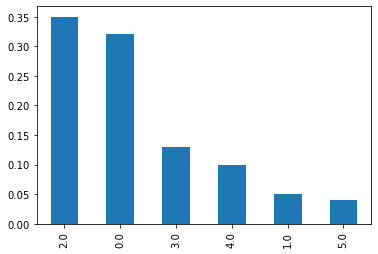

In [359]:
# Bar plot to see the most common topic

round(negative.topic_id.value_counts()/len(negative), 2).plot(kind = "bar");

In [360]:
print(min(negative.topic_score), max(negative.topic_score))

0.1666666716337204 0.7889366149902344


In [361]:
# Positive reviews

positive = df_sen.loc[df_sen['sentiment'] == 'pos']

In [362]:
positive.shape

(11727, 14)

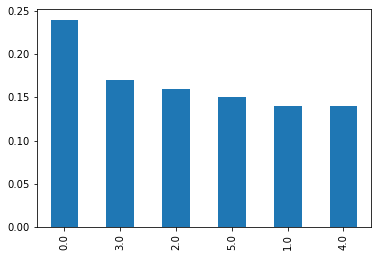

In [363]:
round(positive.topic_id.value_counts()/len(positive), 2).plot(kind = 'bar');

In [364]:
print(min(positive.topic_score), max(positive.topic_score))

0.1666666716337204 0.8251121640205383


In [365]:
# Neutral reviews

neutral = df_sen.loc[df_sen['sentiment'] == 'neu']

In [366]:
neutral.shape

(2407, 14)

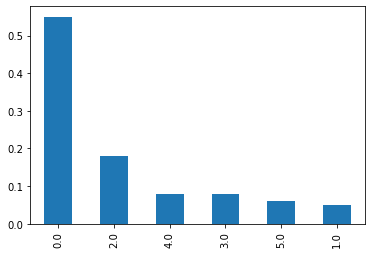

In [367]:
round(neutral.topic_id.value_counts()/len(neutral), 2).plot(kind = 'bar');

In [368]:
print(min(neutral.topic_score), max(neutral.topic_score))

0.1666666716337204 0.7980325222015381
